In [6]:

from air.datasets.quantum_exp import StateTomography, generate_quantum_dataset

from air.models import VAIR

from air.losses_metrics import beta_mse_loss, save_logvars, save_separate_losses



import numpy as np
import torch
from fastai.vision.all import Learner, Adam

DEVICE = 'cuda'

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

colors = np.array(['#1a7dd7ff', '#f2b809ff', '#f34605ff'])
cmap = LinearSegmentedColormap.from_list(
    "custom_cmap",
    [colors[0], colors[1], colors[2]]
)

# Training

In [2]:
batch_size = 200
beta = 1e-3
lr = 1e-4
dataset_size = int(6e3)

seed = 11
np.random.seed(seed)
torch.manual_seed(seed)


tomography = StateTomography(num_qubits=2,
                            num_measure = 75, 
                            num_random_actions= 0,
                            num_datapoints = dataset_size) 

data, loader = generate_quantum_dataset(tomography, batch_size)

In [3]:
dim_x = tomography.num_measure # Dimension input to encoder
dim_z = 15
dim_a = int(np.prod(tomography.action_measures[0].shape)*2)
dim_y = 1

AE = VAIR(dim_x = dim_x,
          dim_z = dim_z,
          dim_a = dim_a, 
          dim_y = dim_y,
         ).to(DEVICE)

In [4]:
learn = Learner(data, 
                    AE,
                    loss_func = beta_mse_loss(loss_objective = 'H',
                                            beta = beta,
                                            recon_objective='mse'), 
                    opt_func= Adam,
                    cbs = save_separate_losses(loader)
                    )

    
with learn.no_logging(): learn.fit(100, lr = 1e-4)

[Text(0.5, 0, 'Epoch'), Text(0.5, 0, 'Epoch')]

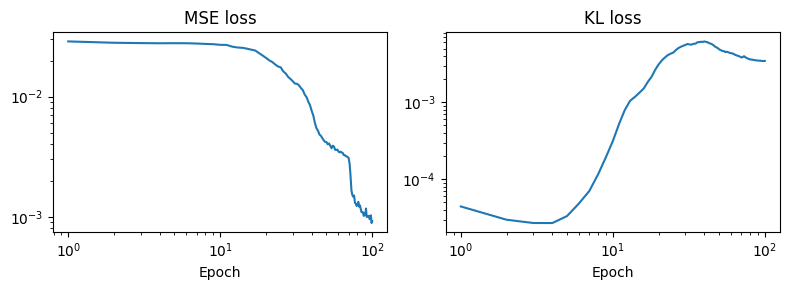

In [74]:
fig, ax = plt.subplots(1, 2, figsize = (8,3), tight_layout = True)

ax[0].loglog(torch.arange(1,2+learn.epoch), learn.save_separate_losses.mse_loss)
ax[0].set_title('MSE loss')

ax[1].loglog(torch.arange(1,2+learn.epoch), learn.save_separate_losses.kl_loss)
ax[1].set_title('KL loss')

plt.setp(ax, xlabel = 'Epoch')

# Action representation

In [69]:
projectors = torch.tensor(tomography.get_training_data()[-1])

action_rep = torch.cat([actions.real.view(15, -1), 
                        actions.imag.view(15, -1)], dim=1)

''

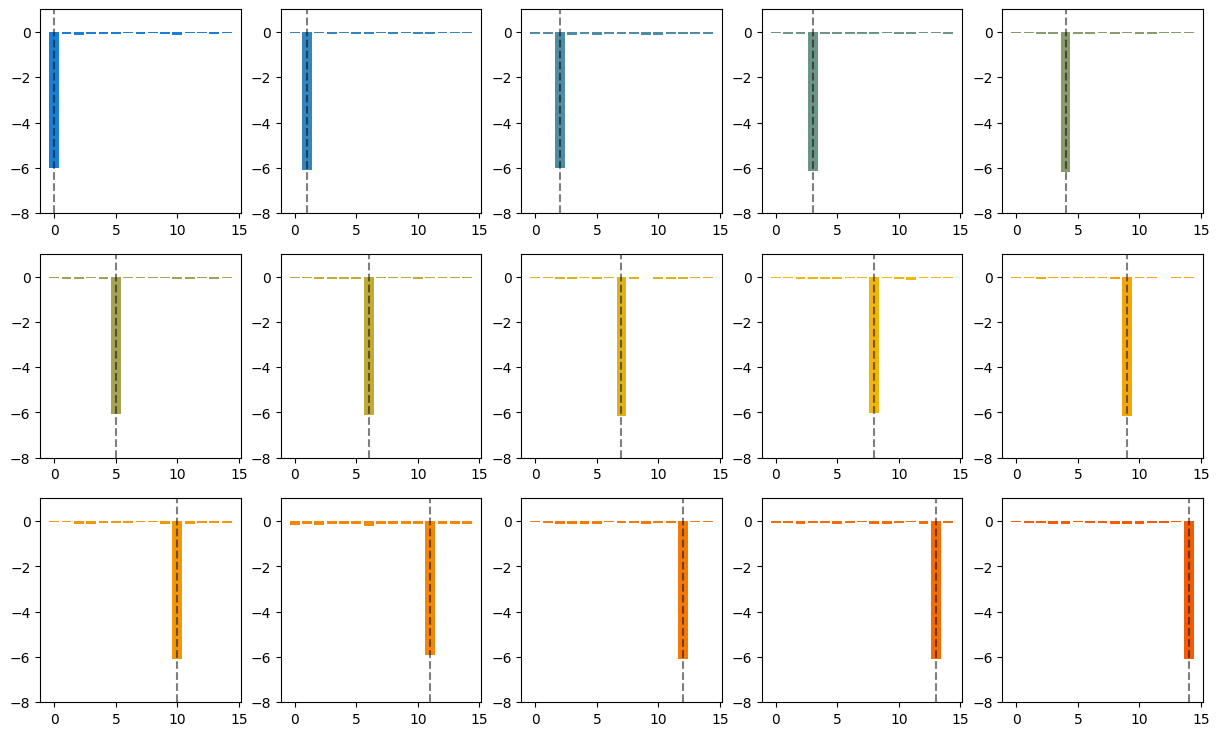

In [85]:
num_actions = 15
fig, axs = plt.subplots(3, 5, figsize = (5*3, 3*3))
colors_logvar = cmap(np.linspace(0., 0.9, num_actions))

for act_idx, ax in zip(range(num_actions), axs.flatten()):

    active_z = learn.E_a(action_rep[act_idx].to(torch.float).to('cuda')).detach().cpu()

    max_index = torch.abs(active_z).argmax().item()

    indices = [i for i in range(num_actions) if i != max_index]
    indices.insert(act_idx, max_index)

    ax.bar(np.arange(len(active_z)), [active_z[i] for i in indices], facecolor = colors_logvar[act_idx])

    ax.axvline(act_idx, ls = '--', c= 'k', alpha = 0.5)
    
plt.setp(axs, ylim = (-8, 1,))
;

# Observation representation

In [46]:
from air.datasets.quantum_exp import get_test_data

In [76]:
num_datapoints = 100

test_data = get_test_data(tomography, num_datapoints)

In [81]:
colors_mu = cmap(np.linspace(0., 0.9, num_actions))

''

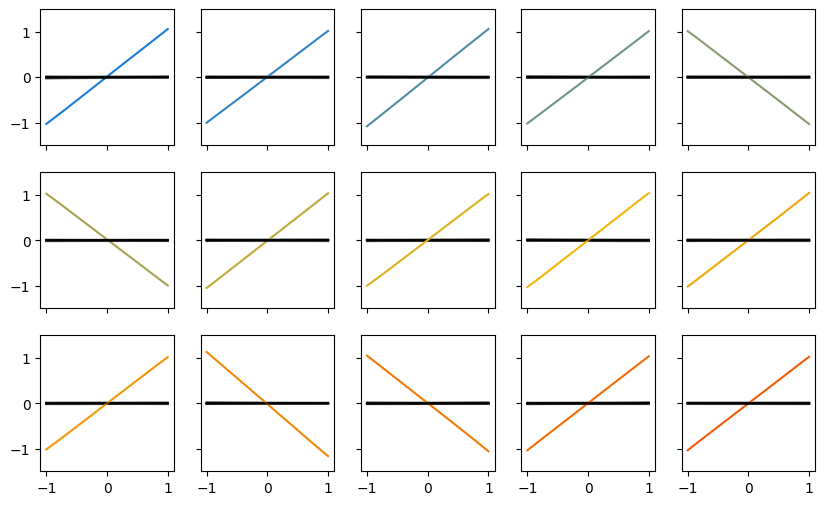

In [87]:
num_actions = 15
fig, axs = plt.subplots(3, 5, figsize = (5*2, 3*2))

colors_mu = cmap(np.linspace(0., 0.9, num_actions))


mus = torch.zeros((num_actions, num_datapoints, dim_z))



for act_idx, ax in zip(range(num_actions), axs.flatten()):
   
    active_z = learn.E_a(action_rep[act_idx].to(torch.float).to(DEVICE)).argmin()
    
    # X_test = get_test_data(tomography)
    X = test_data[act_idx].to(DEVICE)
    mu_range = learn.E_x(X)

    mus[active_z] = mu_range
    
    x_values = np.linspace(-1., 1., num_datapoints)  # Size 0 is 11
    
   
    for i in range(mu_range.size(1)): 

        ax.plot(x_values, mu_range[:, i].detach().cpu(),
                c = colors_mu[act_idx] if i == active_z else 'k',
                alpha = 1 if i == active_z else 0.3)        
        
plt.setp(axs, ylim = (-1.5,1.5))
plt.setp(axs[:,1:], yticklabels = [])
plt.setp(axs[:-1,:], xticklabels = [])
;

# Action combination

In [57]:
weights_m = np.array([0.1,0.2,0.3])
weights_m /= sum(weights_m)

actions_chosen = [4,1,2]

mixed_action = 0
active_zs_idx, active_zs_value = [], []
for action_idx, weight in zip(actions_chosen, weights_m):
    mixed_action += weight*action_rep[action_idx]

    logvars = learn.E_a(action_rep[action_idx].to(torch.float).to('cuda')).detach().cpu()
    
    active_zs_idx.append(int(logvars.argmin()))
    active_zs_value.append(int(logvars.min()))

logvars_mixed = learn.E_a(mixed_action.to(torch.float).to('cuda')).detach().cpu()

[-6.5,
 0.1,
 Text(0, 0.5, '$\\log(\\sigma^2)$'),
 Text(0.5, 0, 'Latent neuron'),
 Text(0.5, 1.0, '$A = w_1A_1 + w_2A_2 + w_3A_3$')]

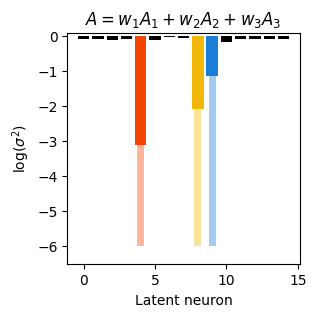

In [61]:
fig, axs = plt.subplots(1, 1, figsize = (3, 3))


# We create a color pattern such that the logvars of the neurons active for each separate
# action are colored 
bar_colors = np.array(['#000000ff'] * logvars_mixed.shape[0])
for i, idx in enumerate(active_zs_idx):
    bar_colors[idx] = colors[i]

axs.bar(np.arange(len(logvars_mixed)), logvars_mixed, color=bar_colors)

for idx, (val, x) in enumerate(zip(active_zs_value, active_zs_idx)):
    axs.bar(x, val, color = colors[idx], width = 0.5, alpha = 0.4)

plt.setp(axs, ylim = (-6.5, 0.1), 
         ylabel = r'$\log(\sigma^2)$', xlabel = 'Latent neuron',
         title = r'$A = w_1A_1 + w_2A_2 + w_3A_3$')